# Ames House Price Prediction


#### The goal for this project to estimate the sales price of houses in Ames, Iowa.


## Import Libriaries

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import stats
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression,ElasticNet, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_squared_log_error

from xgboost.sklearn import XGBRegressor
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load  Data

In [3]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

The data set used in this project describes the sale of houses in Ames, Iowa from January 2006 to July 2010. 
<br> The full data set contains 2930 observations and 81 attributes, of which 35 is quantitative, 43 categorical + Id and SalePrice

## Data Cleaning

In [4]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**Missing Values**

In [7]:
train.isnull().sum().sort_values(ascending=False)[:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [8]:
test.isnull().sum().sort_values(ascending=False)[:35]

PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Exterior1st        1
KitchenQual        1
GarageArea         1
GarageCars         1
HouseStyle         0
LandSlope          0
dtype: int64

There are 19 columns with missing data in train dataset and 32 columns in test dataset.

**From the data description I know that there is a category 'NA' for each categorical column (such as PoolQC, MiscFeature, Alley and others). But Pandas recognized the 'NA' as a missing value so I will replace them**

In [9]:
categorical_columns_na = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageCond', 
              'GarageQual', 'GarageType', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 
              'BsmtQual']

[train[x].fillna('NA', inplace=True) for x in categorical_columns_na]
[test[x].fillna('NA', inplace=True) for x in categorical_columns_na];

In [10]:
#Mas Vnr Type has category 'None' so replece Nan value None
train['MasVnrType'].fillna('None',inplace=True )
test['MasVnrType'].fillna('None',inplace=True )

**For most numeric data I've decided to replace them with 0<br>**
It makes sense because Nan values in the most numeric columns mean an absence of features (ex. Garage Area = 0 because there is no garage in the house)

In [11]:
numeric_columns = ['GarageYrBlt', 'MasVnrArea','BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'GarageArea',
                   'BsmtUnfSF', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtFinSF1','Electrical']

[train[x].replace(np.nan, 0 , inplace=True) for x in numeric_columns]
[test[x].replace(np.nan, 0 , inplace=True) for x in numeric_columns];

**Lot Frontage missing values** <br>
Impute nan values by ('Neighborhood') median

In [12]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
test['LotFrontage'] = test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**Other columns missing values** 

In [13]:
categorical_columns_mode = ['Utilities', 'MSZoning', 'Functional','SaleType', 'Exterior1st', 'Exterior2nd','KitchenQual']

[train[x].fillna(train[x].mode()[0], inplace=True) for x in categorical_columns_mode]
[test[x].fillna(train[x].mode()[0], inplace=True) for x in categorical_columns_mode];

In [14]:
#check nan values 
test.isnull().sum().sort_values(ascending=False)[:5]

SaleCondition    0
SaleType         0
RoofStyle        0
RoofMatl         0
Exterior1st      0
dtype: int64

## EDA

In [15]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1460.0,70.199658,22.431902,21.0,60.00,70.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


### Pairplot/outliers

In [16]:
#chose numeric features for pairplot
cols = ['LotFrontage','LotArea','YearBuilt', 'YearRemodAdd',
        'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF','1stFlrSF', '2ndFlrSF',
        'MasVnrArea', 'MoSold', 'YrSold', 'Fireplaces', 'MiscVal','GrLivArea',
        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
        'GarageCars', 'GarageArea','WoodDeckSF', 'OpenPorchSF', 'ScreenPorch', 'PoolArea',
       ]

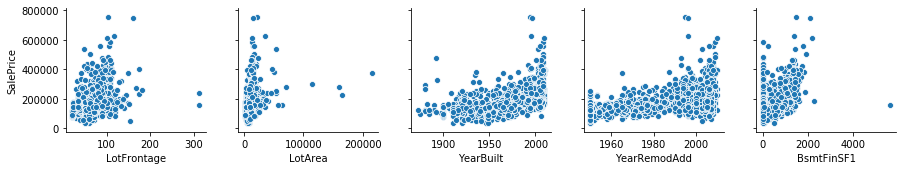

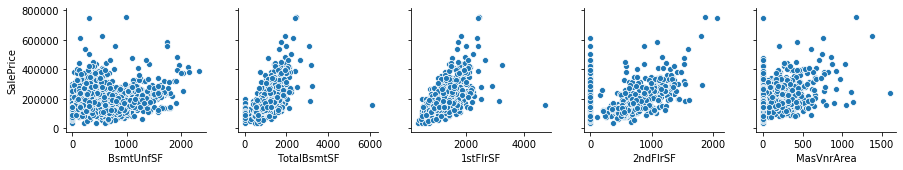

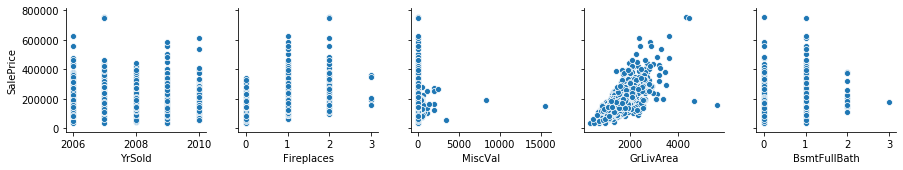

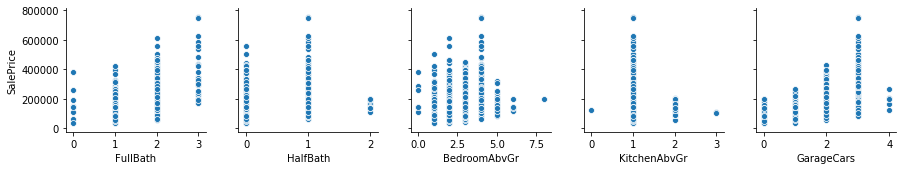

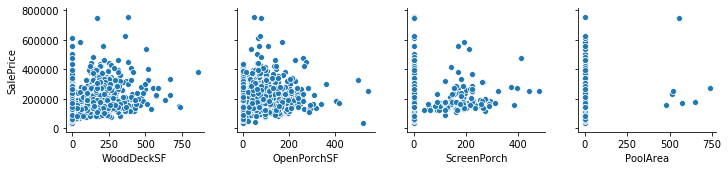

In [17]:
for i in range(0,30,6):
    sns.pairplot(train, y_vars=['SalePrice'], x_vars=cols[i:i+5])

The Plots above show some outliers which can affect the linear regression model. 
I decided to remove the strongest outliers from the train dataset.

In [24]:
train = train[(train['LotArea']<150000)&(train['LotFrontage']<300)&
       (train['BsmtFinSF1']<4000)&(train['TotalBsmtSF']<6000)&
       (train['1stFlrSF']<4000)&(train['GrLivArea']<5000)]

In [25]:
train.shape 

(1455, 81)

### Skewness

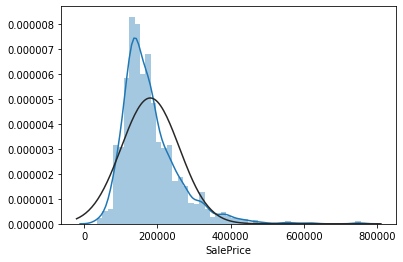

In [26]:
sns.distplot(train['SalePrice'], fit=norm);

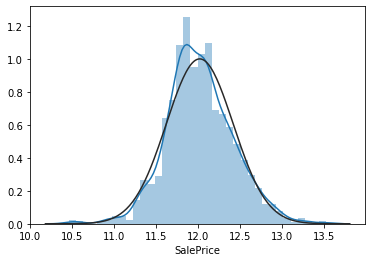

In [27]:
sns.distplot(np.log(train['SalePrice']), fit=norm);

In [28]:
train.skew(axis = 0).sort_values(ascending=False)

MiscVal          24.502948
PoolArea         15.932369
3SsnPorch        10.286243
LowQualFinSF      8.995367
LotArea           6.276086
KitchenAbvGr      4.479607
BsmtFinSF2        4.285307
BsmtHalfBath      4.127311
ScreenPorch       4.113996
EnclosedPorch     3.083098
MasVnrArea        2.692210
OpenPorchSF       2.369120
SalePrice         1.894238
WoodDeckSF        1.516098
MSSubClass        1.404003
GrLivArea         1.127668
1stFlrSF          0.958054
BsmtUnfSF         0.918149
2ndFlrSF          0.813935
BsmtFinSF1        0.797722
OverallCond       0.695912
HalfBath          0.673595
TotRmsAbvGrd      0.669084
LotFrontage       0.641912
Fireplaces        0.632958
TotalBsmtSF       0.573525
BsmtFullBath      0.573372
BedroomAbvGr      0.215338
MoSold            0.215110
OverallQual       0.209869
GarageArea        0.132631
YrSold            0.097323
FullBath          0.043070
Id               -0.002059
GarageCars       -0.339026
YearRemodAdd     -0.504118
YearBuilt        -0.614761
G

Skewness is a problem for linear regression. 
And there is a simple approach which can work well with this problem very well, it is log transformation. 
We have to use log transformation for skewed data. I will do it in Preprocessing and Feature engineering step

### Correlations/Heatmap

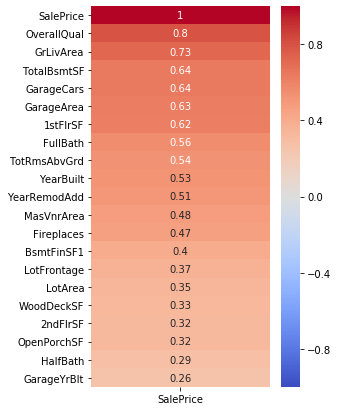

In [29]:
plt.figure(figsize=(4,7))
sns.heatmap(train.corr()[['SalePrice']][train.corr()['SalePrice'] >= 0.25].
            sort_values('SalePrice',ascending=False),annot=True,cmap='coolwarm',vmin= -1);

Overall quality has the highest correlation with Saleprice among the numeric variables (0.8). It's on a scale from 1 (very poor) to 10 (very excellent)
Footage, year built and baths also have high correlations with Saleprice.

### Categorical variables

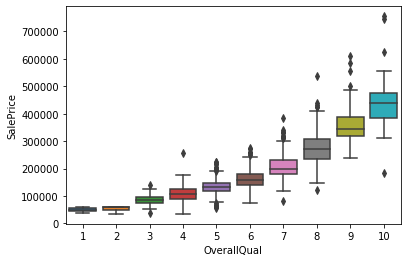

In [30]:
sns.boxplot(x='OverallQual', y='SalePrice', data=train);

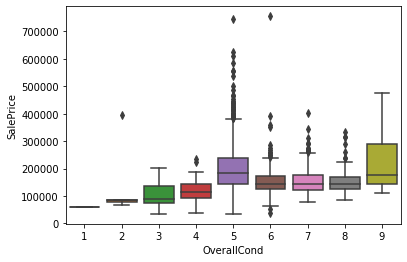

In [31]:
sns.boxplot(x='OverallCond', y='SalePrice', data=train);

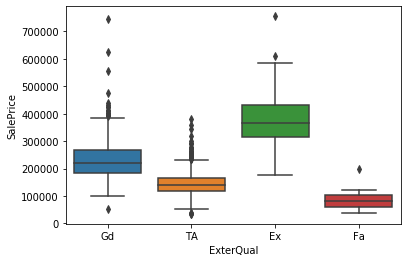

In [32]:
sns.boxplot(x='ExterQual', y='SalePrice', data=train);

Overall_qual and Overall_cond show strong linear relationship with Sale Price.

- The dataset contains 81 explanatory variables (35 is quantitative, 43 categorical + Id and SalePrice) used to describe the house and evaluate its value.
- Overall_qual, Gr_liv_area and Total_bsmt_sf are strongly correlated with SalePrice.
- Garage_cars and garage_area are also some of the most strongly correlated variables but they are dependant from each other
- Saleprice and independent variables have skewness

### Feature Engineering

For feature engineering I decided to merge 2 datasets so that not to do the same work twice and avoid mistakes.

In [33]:
#add new column with train/test identifier
train['train_test'] = 'train'
test['train_test'] = 'test'

In [34]:
df = pd.concat([train,test],ignore_index=True,sort=False)
df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train_test
0,1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,...,NA,NA,NA,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,...,NA,NA,NA,0,9,2008,WD,Normal,223500.0,train


Create 'features' DataFrame to collect all features

In [35]:
features = pd.DataFrame()
#copy train/testidentifierfor splitting  Features dataframe later
features['train_test'] = df['train_test']
#copy saleprice for Y
features['SalePrice'] = df['SalePrice']

There are 3 types of features : numeric, level-categorical and categirical

#### Numeric features (descrete and continuos):

In [36]:
# Total number of bathrooms
features['TotalBath'] = df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']) + df['FullBath'] + (0.5 * df['HalfBath'])
# Total SF for house 
features['TotalSF'] = df['GrLivArea'] + df['TotalBsmtSF']
# Total SF for 1st + 2nd floors
features['TotalFlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']
# Total SF for porch
features['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
# Age 
features['Age'] = 2019 - df[['YearBuilt','YearRemodAdd']].max(axis=1)

Use log transformation for skewed values:

In [37]:
for i in ['TotalBath','TotalSF','TotalFlrSF','TotalPorchSF','Age']:
    features[i] = np.log1p(features[i])

In [38]:
for i in list(train._get_numeric_data()):
    features[i] = np.log1p(df[i])

**Categorical ordinal features:**

In [39]:
cols = ['BsmtQual','BsmtCond','FireplaceQu','GarageQual',
        'GarageCond','PoolQC','ExterCond','ExterQual','HeatingQC','KitchenQual']
rank = {'NA':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

for x in cols:
    features[x] = df[x].map(lambda x: rank.get(x, x))

In [40]:
features['LotShape'] = df['LotShape'].replace({'IR3' : 1, 'IR2' : 2, 'IR1' : 3, 'Reg' : 4})
features['Utilities'] = df['Utilities'].replace({'ELO' : 1, 'NoSeWa' : 2, 'NoSewr' : 3, 'AllPub' : 4})
features['LandSlope'] = df['LandSlope'].replace({'Sev' : 1, 'Mod' : 2, 'Gtl' : 3})
features['BsmtExposure'] = df['BsmtExposure'].replace({'No' : 0,'NA' : 0, 'Mn' : 1, 'Av': 2, 'Gd' : 3})
features['BsmtFinType1'] = df['BsmtFinType1'].replace({'NA' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 
                                         'ALQ' : 5, 'GLQ' : 6})
features['BsmtFinType2'] = df['BsmtFinType2'].replace({'NA' : 0, 'Unf' : 1, 'LwQ': 2, 'Rec' : 3, 'BLQ' : 4, 
                                         'ALQ' : 5, 'GLQ' : 6})
features['Functional'] = df['Functional'].replace({'Sal' : 1, 'Sev' : 2, 'Maj2' : 3, 'Maj1' : 4, 'Mod': 5, 
                                       'Min2' : 6, 'Min1' : 7, 'Typ' : 8})
features['PavedDrive'] = df['PavedDrive'].replace({'N' : 0, 'P' : 1, 'Y' : 2})
features['Fence'] = df['Fence'].replace({'NA' : 0, 'MnWw' : 1, 'GdWo' : 2, 'MnPrv' : 3, 'GdPrv' : 4})

In [41]:
features['OverallQual'] = df['OverallQual']
features['OverallCond'] = df['OverallCond']

#### Categorical nominal features

All categitocal nominal features transform using one-hot encoding

In [42]:
def convert_to_dummies(columns):
    df_dummies = pd.get_dummies(df[columns].astype(str))
    return df_dummies

In [43]:
dummies = convert_to_dummies(['MSSubClass','MoSold','Neighborhood', 'Street','MSZoning',
                              'Condition1','Condition2','Electrical','BldgType'
                             ])
features = features.join(dummies)

#### Correlations between features

To remove noisy or multi-collinear features check correlation between features:

In [44]:
corr = features.corr()
cols = features[features.columns[~features.columns.isin(['train_test','saleprice'])]].columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        i_feat = cols[i];
        j_feat = cols[j];
        if corr[i_feat][j_feat] > 0.9:
            print((i_feat, j_feat, corr[i_feat][j_feat]))

('TotalFlrSF', 'GrLivArea', 0.9953501717738146)
('Fireplaces', 'FireplaceQu', 0.9178404794559242)
('GarageYrBlt', 'GarageArea', 0.9642967577879916)
('GarageYrBlt', 'GarageQual', 0.9401286636135933)
('GarageYrBlt', 'GarageCond', 0.9469642915947167)
('GarageArea', 'GarageQual', 0.9273902347042371)
('GarageArea', 'GarageCond', 0.9274405618614429)
('GarageQual', 'GarageCond', 0.9466495882092603)
('MSSubClass_190', 'BldgType_2fmCon', 0.9747156921960598)
('MSSubClass_90', 'BldgType_Duplex', 1.0)


In [45]:
del_columns = ['TotalFlrSF','FireplaceQu', 'GarageCond', 'BldgType_Duplex', 'BldgType_2fmCon']
features.drop(del_columns, axis=1,inplace=True)

#### Additional features

In [46]:
corr = features.corr()
corr.sort_values(['SalePrice'], ascending = False, inplace = True)
print(corr['SalePrice'][:15])

SalePrice       1.000000
OverallQual     0.821252
TotalSF         0.810331
GrLivArea       0.734101
ExterQual       0.684017
TotalBath       0.674781
KitchenQual     0.671780
GarageCars      0.642005
BsmtQual        0.616978
1stFlrSF        0.611877
YearBuilt       0.587359
FullBath        0.579651
YearRemodAdd    0.568391
TotRmsAbvGrd    0.540646
Fireplaces      0.507732
Name: SalePrice, dtype: float64


In [47]:
poly = PolynomialFeatures(include_bias=False)

In [48]:
transform_columns = features[['OverallQual','TotalSF','GrLivArea','ExterQual',
                              'KitchenQual','GarageCars','TotalBath','BsmtQual','YearBuilt']]
features_poly = poly.fit_transform(transform_columns)
l = poly.get_feature_names(transform_columns.columns) 

In [49]:
f = pd.DataFrame(features_poly, columns = l)
f.drop(['OverallQual','TotalSF','GrLivArea','ExterQual',
                              'KitchenQual','GarageCars','TotalBath','BsmtQual','YearBuilt'],axis=1,inplace=True)

In [50]:
features = features.join(f) 

Divide features dataset to train and kaggle:

In [51]:
kaggle_features = features[features['train_test']=='test']

In [52]:
kaggle_features.drop(['train_test'], axis=1,inplace=True)
kaggle_features.drop(['SalePrice'], axis=1,inplace=True)

In [53]:
train_features = features[features['train_test']=='train']

In [54]:
train_features.drop(['train_test'], axis=1,inplace=True)

### Model Prep: Create our features matrix (X) and target vector (y)

In [55]:
X = train_features.drop(['SalePrice'], axis=1)
y = train_features['SalePrice']

### Model Prep: Train/test split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=21)

### Modeling 

**Lasso Regression**

In [67]:
pipe_lasso = Pipeline([
    ('ss', RobustScaler()),
    ('lasso', Lasso())
])

params_lasso = {
    'lasso__alpha': np.logspace(-5, 2, 30)
}

gs_lasso = GridSearchCV(pipe_lasso,
                        param_grid=params_lasso,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_lasso.fit(X_train, y_train);

lasso_preds = gs_lasso.predict(X) 
lasso_preds = np.exp(lasso_preds)

print(f'GridSearch Best Params: {gs_lasso.best_params_}')
print('Train Score:', gs_lasso.score(X_train, y_train))
print('Test Score:', gs_lasso.score(X_test, y_test))


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done 147 out of 150 | elapsed:   12.2s remaining:    0.2s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   12.3s finished


GridSearch Best Params: {'lasso__alpha': 0.0008531678524172815}
Train Score: 0.9263970837517459
Test Score: 0.9162985707473119


**Ridge Regression**

In [68]:
pipe_ridge = Pipeline([
    ('ss', RobustScaler()),
    ('ridge', Ridge())
])

params_ridge = {
    'ridge__alpha': np.arange(0.0, 10.0, 0.2)
}

gs_ridge = GridSearchCV(pipe_ridge,
                        param_grid=params_ridge,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_ridge.fit(X_train, y_train)

ridge_preds = gs_ridge.predict(X) 
ridge_preds = np.exp(ridge_preds)

print(f'GridSearch Best Params: {gs_ridge.best_params_}')
print('Train Score:', gs_ridge.score(X_train, y_train))
print('Test Score:', gs_ridge.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    3.8s


GridSearch Best Params: {'ridge__alpha': 7.4}
Train Score: 0.9324180083813631
Test Score: 0.9161717569757682


[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:   10.0s finished


**ElasticNet Regression**

In [69]:
pipe_elastic = Pipeline([
    ('ss', RobustScaler()),
    ('elastic', ElasticNet())
])

params_elastic = {
    "elastic__alpha": [0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00001]
    }
    

gs_elastic = GridSearchCV(pipe_elastic,
                        param_grid=params_elastic,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_elastic.fit(X_train, y_train)

elastic_preds = gs_elastic.predict(X) 
elastic_preds = np.exp(elastic_preds)


print(f'GridSearch Best Params: {gs_elastic.best_params_}')
print('Train Score:', gs_elastic.score(X_train, y_train))
print('Test Score:', gs_elastic.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch Best Params: {'elastic__alpha': 0.001}
Train Score: 0.9307873774350383
Test Score: 0.9183335287202672


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    3.5s finished


**XGBRegressor**

In [114]:
pipe_xgboost = Pipeline([
    ('ss', StandardScaler()),
    ('xgboost', XGBRegressor())
])

params_xgboost = {
    "xgboost__learning_rate": [0.01,0.06,0.08,0.1],
    "xgboost__max_depth": [3],
    "xgboost__n_estimators": [500],
    "xgboost__random_state": [0],
    "xgboost__reg_alpha": [0.00006]
    
     }
    
gs_xgboost = GridSearchCV(pipe_xgboost,
                        param_grid=params_xgboost,
                        cv=5,
                        n_jobs=2,
                        verbose=1)

gs_xgboost.fit(X_train, y_train)

xgboost_preds = gs_xgboost.predict(X) 
xgboost_preds = np.exp(xgboost_preds)


print(f'GridSearch Best Params: {gs_xgboost.best_params_}')
print('Train Score:', gs_xgboost.score(X_train, y_train))
print('Test Score:', gs_xgboost.score(X_test, y_test))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.0min finished


[21:25:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
GridSearch Best Params: {'xgboost__learning_rate': 0.08, 'xgboost__max_depth': 3, 'xgboost__n_estimators': 500, 'xgboost__random_state': 0, 'xgboost__reg_alpha': 6e-05}
Train Score: 0.991456589480889
Test Score: 0.8827785724039225


### Stacked Predictions

In [116]:
stacked_preds = (0.2 *  lasso_preds + 0.2 * ridge_preds+ 0.2 * elastic_preds +  0.4 * xgboost_preds) 

### Model Evaluation

In [98]:
def metrics (y, predictions):
    print('Root Mean Squared Error is',round(np.sqrt(mean_squared_error(y,np.log(predictions))),4))
    print('R2 Score is',round(r2_score(np.exp(y),predictions),4))

In [110]:
metrics(y, stacked_preds)

Root Mean Squared Error is 0.0824
R2 Score is 0.9502


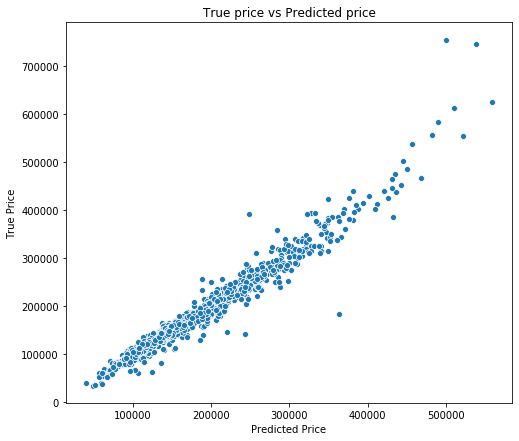

In [111]:
plt.figure(figsize=(8,7))
# Generate a scatterplot of predicted values versus actual values.
sns.scatterplot(stacked_preds, np.exp(y))
plt.xlabel('Predicted Price')
plt.ylabel('True Price')
plt.title('True price vs Predicted price');

### Kaggle Prediction and Submission 

In [124]:
X_kaggle = kaggle_features
preds = (0.2 * gs_lasso.predict(X_kaggle) + 0.2 * gs_ridge.predict(X_kaggle) + 0.2 * gs_elastic.predict(X_kaggle) 
        + 0.4 * gs_xgboost.predict(X_kaggle))
#preds = stack_gen.predict(X_kaggle) 
preds = np.exp(preds)
sub = pd.DataFrame({'id': test['Id'], 'SalePrice': preds})
sub.to_csv('./datasets/kaggle_sub.csv', index=False)

### Conclusions 

This competition was a great exercise in some regression techniques. I was able to achieve a top 30% score even though I performed minimal feature engineering, which I will leave as a later exercise for myself.

The model that performs the best was is which got me in the top 30% on Kaggle competition and 1st place in in-class competition is stacking model (Lasso, Ridge, Enet, XGBoost) with R2 Score 95%

In [131]:
90+50+65+85+72+210+155

727